In [1]:
import os
import cv2
import random

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from random import randint

from sklearn.utils import shuffle

from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def plotImagenes(imagenes):

  fig, ax = plt.subplots(1, len(imagenes), figsize = (12, 6))

  for i in range(len(ax)):

    ax[i].axis('off')
    ax[i].imshow(imagenes[i])

  plt.show()

## Modelo de segmentación basado en UNet

In [4]:
# Generador de lista con número de filtros [filtro*2^0, filtro*2^1, filtro*2^2 ... filtro*2^n]

def filtros(dim, ndims):

  return [dim*(2**i) for i in range(ndims)]

In [5]:
# Bloque de convolución.
# Convolución.
# Dropout.
# Convolución.
# Batch Normalization.
# ReLU.
# MaxPooling2D.

def bloqueConvolucion(input, filtro, dropout = 0.1):

  c1 = tf.keras.layers.Conv2D(filtro, (3,3), # Primera convolución.
                              activation = 'relu',
                              kernel_initializer = 'he_normal',
                              padding = 'same')(input)

  c1 = tf.keras.layers.Dropout(dropout)(c1) # Dropout.

  c1 = tf.keras.layers.Conv2D(filtro, (3,3),
                              activation = 'relu',
                              kernel_initializer = 'he_normal',
                              padding = 'same')(c1)

  b1 = tf.keras.layers.BatchNormalization()(c1) # Normalización del lote.
  r1 = tf.keras.layers.ReLU()(b1)
  p1 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(r1)

  return p1, c1 # Última capa y capa a conectar.

In [6]:
# Convolución.
# ReLU.
# Dropout.
# Convolución.

def ultimaConvolucion(input, filtro, dropout = 0.1):

  c1 = tf.keras.layers.Conv2D(filtro, (3, 3),
                              activation = 'relu',
                              kernel_initializer = 'he_normal',
                              padding = 'same')(input)

  b1 = tf.keras.layers.BatchNormalization()(c1)
  r1 = tf.keras.layers.ReLU()(b1)

  c2 = tf.keras.layers.Dropout(rate = dropout)(r1)

  c2 = tf.keras.layers.Conv2D(filtro, (3, 3),
                              activation = 'relu',
                              kernel_initializer = 'he_normal',
                              padding = 'same')(c2)

  return c2

In [7]:
# Transponer.
# Concatenar.
# Normalización.
# ReLU.

def bloqueDeConv(input, conectar, filtro, dropout = 0.1):

  t = tf.keras.layers.Conv2DTranspose(filtro, (2, 2),
                                      strides = (2,2),
                                      padding = 'same')(input)

  concatena = tf.keras.layers.concatenate([t, conectar])

  b = tf.keras.layers.BatchNormalization()(concatena)
  r = tf.keras.layers.ReLU()(b)

  return b

In [8]:
def uNetModel_1(input_shape, filter, nfilter):

  inputs = tf.keras.layers.Input(shape = input_shape) # Capa de entrada.
  dims = filtros(filter, nfilter)

  sig = inputs
  layersCon = []

  for i in range(len(dims) - 1):

    sig, con = bloqueConvolucion(sig, dims[i])
    layersCon.append(con)

  sig = ultimaConvolucion(sig, dims[-1])

  ndims = dims[0:-1]
  ndims.reverse()

  layersCon.reverse()

  for i in range(len(layersCon)):

    sig = bloqueDeConv(sig, layersCon[i], ndims[i])

  outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(sig)

  return tf.keras.Model(inputs = [inputs], outputs = [outputs])

## Segmentación RT


In [ ]:
!mkdir /content/imagenes;
!unzip -q /content/drive/MyDrive/Internado/InternadoV2/Datasets/rtorax_256.zip -d /content/imagenes

In [ ]:
PATH_IMAG = '/content/imagenes/rtorax_256/im256'
PATH_MASK = '/content/imagenes/rtorax_256/mascaras256'

img = sorted(os.listdir(PATH_IMAG))
msc = sorted(os.listdir(PATH_MASK))

In [ ]:
imagenes = [cv2.cvtColor(cv2.imread(PATH_IMAG + '/' + i), cv2.COLOR_BGR2GRAY) for i in img]
mascaras = [cv2.cvtColor(cv2.imread(PATH_MASK + '/' + i), cv2.COLOR_BGR2GRAY) for i in msc]

imagenesNorm = np.array([i/np.max(i) for i in imagenes])
mascarasNorm = np.array([i/np.max(i) for i in mascaras])

In [ ]:
np.random.seed(42)

total = shuffle([imagenesNorm, mascarasNorm])

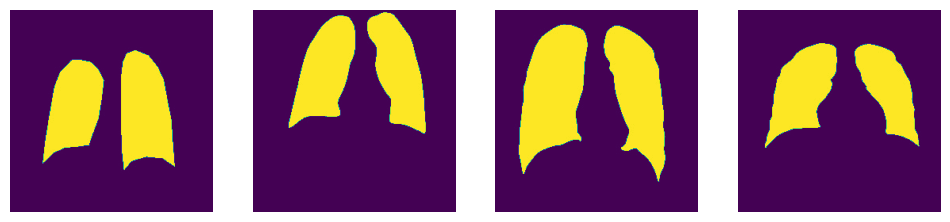

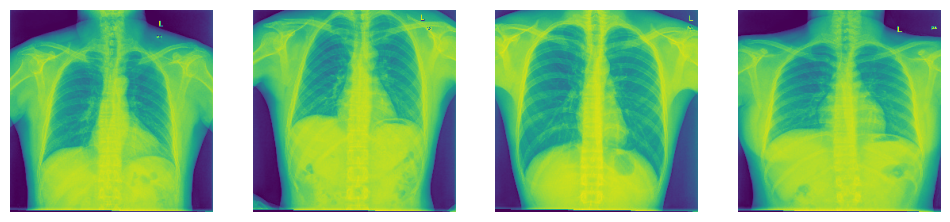

In [ ]:
plotImagenes(total[0][1:5])
plotImagenes(total[1][1:5])

In [ ]:
es = EarlyStopping(monitor = 'val_loss', patience = 8)
op = Adam(lr = 0.001) # Entrenaremos 4.


modelo = uNetModel_1(input_shape = (256, 256, 1), filter = 8, nfilter = 7)
modelo.compile(optimizer = op, loss = 'binary_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
resultados = modelo.fit(total[1],
                        total[0],
                        batch_size = 32,
                        epochs = 40,
                        validation_split = 0.10,
                        callbacks = [es])

In [ ]:
keys = resultados.history.keys()

PATH = '/content/drive/MyDrive/Internado/InternadoV2/Modelos/segmentacionRT_0001_256/saved_model_5/'

modelo.save(PATH)

for j in keys:

  PATH_AUX = PATH + 'modelo5_0001_' + j + '.txt'

  with open(PATH_AUX, 'w') as f:

    for k in resultados.history[j]: f.write(str(k) + '\n')

## Segmentación CT

### Pre-procesamiento de las imágenes (primer entrenamiento)

In [9]:
!mkdir /content/imagenes;
!unzip -q /content/drive/MyDrive/Internado/InternadoV2/Datasets/ctChest.zip -d /content/imagenes

In [10]:
PATH_IMAG = '/content/imagenes/ctChest/Imagenes'
PATH_MASC_CORAZON = '/content/imagenes/ctChest/Corazon'
PATH_MASC_PULMON = '/content/imagenes/ctChest/Pulmones'
PATH_MASC_TRAQUEA = '/content/imagenes/ctChest/Traquea'

image = sorted(os.listdir(PATH_IMAG))
cora = sorted(os.listdir(PATH_MASC_CORAZON))
pulm = sorted(os.listdir(PATH_MASC_PULMON))
traq = sorted(os.listdir(PATH_MASC_TRAQUEA))

In [11]:
imagenes = [cv2.cvtColor(cv2.imread(PATH_IMAG + '/' + i), cv2.COLOR_BGR2GRAY) for i in image[0:1200]] # Imágenes CT.
mascPulmon = [cv2.cvtColor(cv2.imread(PATH_MASC_PULMON + '/' + i), cv2.COLOR_BGR2GRAY) for i in pulm[0:1200]] # Máscaras del pulmón.

imagenes = np.array([i/np.max(i) for i in imagenes])
mascPulmon = np.array([i/np.max(i) if np.max(i) != 0 else i for i in mascPulmon]) # Normalizamos.

In [12]:
np.random.seed(42)

In [13]:
for i in range(1, 7):

  total = shuffle([imagenes, mascPulmon])

  es = EarlyStopping(monitor = 'val_loss', patience = 8)
  op = Adam(learning_rate = 0.001) # Entrenaremos 4.


  modelo = uNetModel_1(input_shape = (256, 256, 1), filter = 8, nfilter = 7)
  modelo.compile(optimizer = op, loss = 'binary_crossentropy', metrics = ['accuracy'])

  resultados = modelo.fit(total[1],
                          total[0],
                          batch_size = 32,
                          epochs = 40,
                          validation_split = 0.10,
                          callbacks = [es])

  keys = resultados.history.keys()

  PATH = '/content/drive/MyDrive/Internado/InternadoV2/Modelos/segmentacionCT_0001_256/saved_model_{}/'.format(i)

  modelo.save(PATH)

  for j in keys:

    PATH_AUX = PATH + 'modelo{}_0001_'.format(i) + j + '.txt'

    with open(PATH_AUX, 'w') as f:

      for k in resultados.history[j]: f.write(str(k) + '\n')

Epoch 1/40
34/34 [==============================] - 33s 244ms/step - loss: 0.5885 - accuracy: 0.7530 - val_loss: 0.3263 - val_accuracy: 0.9495
Epoch 2/40
34/34 [==============================] - 5s 153ms/step - loss: 0.3262 - accuracy: 0.9300 - val_loss: 0.0974 - val_accuracy: 1.0000
Epoch 3/40
34/34 [==============================] - 5s 150ms/step - loss: 0.2223 - accuracy: 0.9565 - val_loss: 0.0626 - val_accuracy: 1.0000
Epoch 4/40
34/34 [==============================] - 5s 150ms/step - loss: 0.1631 - accuracy: 0.9633 - val_loss: 0.0500 - val_accuracy: 1.0000
Epoch 5/40
34/34 [==============================] - 5s 153ms/step - loss: 0.1197 - accuracy: 0.9675 - val_loss: 0.0461 - val_accuracy: 1.0000
Epoch 6/40
34/34 [==============================] - 5s 151ms/step - loss: 0.0961 - accuracy: 0.9681 - val_loss: 0.0386 - val_accuracy: 1.0000
Epoch 7/40
34/34 [==============================] - 5s 154ms/step - loss: 0.0756 - accuracy: 0.9697 - val_loss: 0.0376 - val_accuracy: 1.0000
Epoch

#### Cargar todas las imágenes

In [ ]:
# Cargamos las imágenes primeras 2000 imágenes.

imagenes = [cv2.cvtColor(cv2.imread(PATH_IMAG + '/' + i), cv2.COLOR_BGR2GRAY) for i in image[0:1200]] # Imágenes CT.

#mascCorazon = [cv2.cvtColor(cv2.imread(PATH_MASC_CORAZON + '/' + i), cv2.COLOR_BGR2GRAY) for i in cora[0:2000]] # Máscaras del corazón.
mascPulmon = [cv2.cvtColor(cv2.imread(PATH_MASC_PULMON + '/' + i), cv2.COLOR_BGR2GRAY) for i in pulm[0:1200]] # Máscaras del pulmón.

In [ ]:
imagenes = [i/np.max(i) for i in imagenes]
mascPulmon = [i/np.max(i) for i in mascPulmon]

<ipython-input-6-4914fa483e55>:2: RuntimeWarning: invalid value encountered in true_divide
  mascPulmon = [i/np.max(i) for i in mascPulmon]


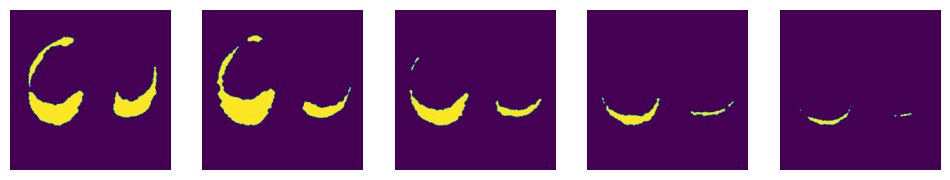

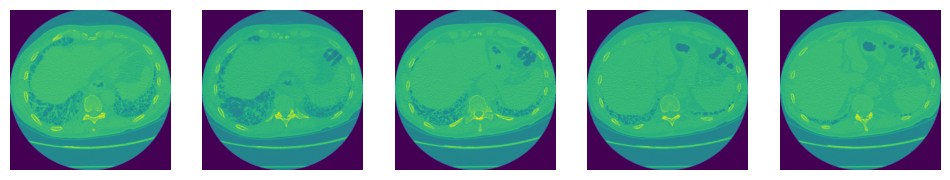

In [ ]:
plotImagenes(mascPulmon[15:20])
plotImagenes(imagenes[15:20])

#### Cargar solamente máscaras de corazón

In [ ]:
soloPulmon = [i for i in range(len(image)) if np.max(cv2.cvtColor(cv2.imread(PATH_MASC_PULMON + '/' + pulm[i]), cv2.COLOR_BGR2GRAY)) != 0] # índices de solo pulmón.
soloCorazon = [i for i in range(len(image)) if np.max(cv2.cvtColor(cv2.imread(PATH_MASC_CORAZON + '/' + cora[i]), cv2.COLOR_BGR2GRAY)) != 0] # índices de solo corazón.

In [ ]:
imgCorazon = [cv2.imread(PATH_IMAG + '/' + image[i]) for i in soloCorazon] # Leemos imágenes del corazón.
imgCorazon = [cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in imgCorazon] # Hacemos blanco y negro.
imgCorazon = np.array([i/np.max(i) for i in imgCorazon]) # Normalizamos.

maskCorazon = [cv2.imread(PATH_MASC_CORAZON + '/' + cora[i]) for i in soloCorazon]
maskCorazon = [cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in maskCorazon]
maskCorazon = np.array([i/np.max(i) for i in maskCorazon])

Imágenes: [444, 394, 124, 72]


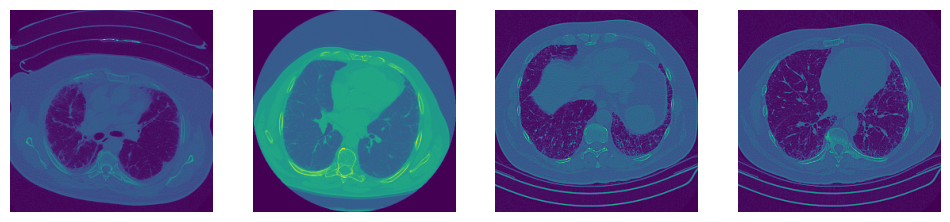

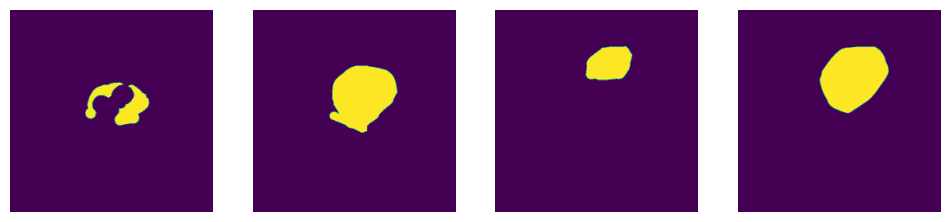

In [ ]:
numim = 4
indx = [randint(0, len(maskCorazon)) for i in range(numim)]
print("Imágenes: {}".format(indx))

plotImagenes([imgCorazon[i] for i in indx])
plotImagenes([maskCorazon[i] for i in indx])

In [ ]:
# Imágenes que solamenten contienen el pulmón (entre la 0 y 4000)

soloPulmon = [i for i in range(len(pulm)) if np.max(cv2.cvtColor(cv2.imread(PATH_MASC_PULMON + '/' + pulm[i]), cv2.COLOR_BGR2GRAY)) != 0]
soloPulmon.sort()

imgPulmon = [cv2.cvtColor(cv2.imread(PATH_MASC_PULMON + '/' + pulm[i]), cv2.COLOR_BGR2GRAY) for i in soloPulmon] # Máscaras que solo contienen a los pulmones.
imgEntradaPulmon = [cv2.cvtColor(cv2.imread(PATH_IMAG + '/' + image[i]), cv2.COLOR_BGR2GRAY) for i in soloPulmon] # Contraparte imágenes.

# Normalizamos.

imgPulmon = np.array([i/np.max(i) for i in imgPulmon])
imgEntradaPulmon = np.array([i/np.max(i) for i in imgEntradaPulmon])

In [ ]:
# Concatenamos.

entradas = np.concatenate((imagenes, imgEntradaPulmon), axis = 0)
salidas = np.concatenate((mascPulmon, imgPulmon), axis = 0)

print(np.shape(entradas))
print(np.shape(salidas))

(3587, 256, 256)
(3587, 256, 256)


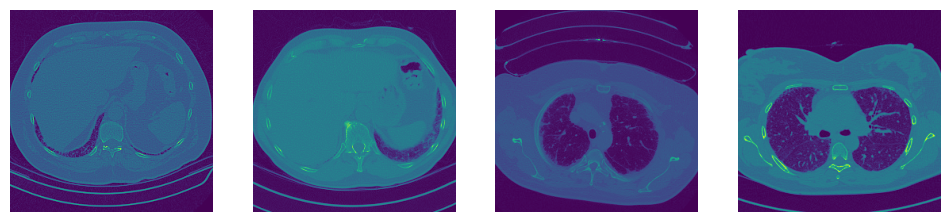

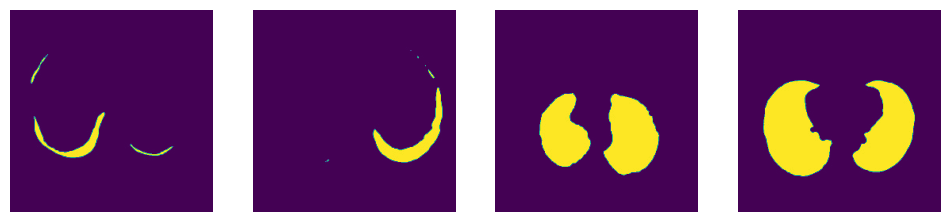

In [ ]:
numim = 4
indx = [randint(0, len(imgPulmon)) for i in range(numim)]

plotImagenes([imgEntradaPulmon[i] for i in indx])
plotImagenes([imgPulmon[i] for i in indx])

In [ ]:
# Características de las imágenes.

imag = 124

print("Características antes la normalización")
print("Valor máximo (CT): {}".format(np.max(imagenes[imag])))
print("Valor máximo (máscara pulmón): {}".format(np.max(mascCorazon[imag])))

# Normalizamos las imágenes.

imgNorm = np.array([i/np.max(i) for i in imagenes])
pulmNorm = np.array([cv2.threshold(i/np.max(i), 0.2, 1, cv2.THRESH_BINARY)[1] for i in mascCorazon])

print("Características antes la normalización")
print("Valor máximo (CT): {}".format(np.max(imgNorm[imag])))
print("Valor máximo (máscara pulmón): {}".format(np.max(pulmNorm[imag])))

Características antes la normalización
Valor máximo (CT): 186
Valor máximo (máscara pulmón): 255


<ipython-input-12-8e052a802b33>:12: RuntimeWarning: invalid value encountered in true_divide
  pulmNorm = np.array([cv2.threshold(i/np.max(i), 0.2, 1, cv2.THRESH_BINARY)[1] for i in mascCorazon])


Características antes la normalización
Valor máximo (CT): 1.0
Valor máximo (máscara pulmón): 1.0


In [ ]:
print(np.shape(pulmNorm[imag]))

(256, 256)


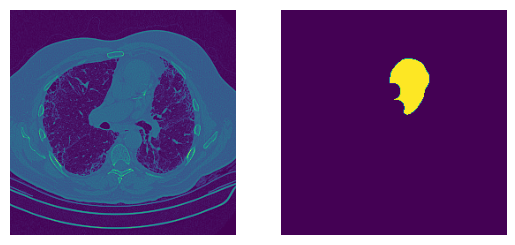

In [ ]:
fig, ax = plt.subplots(1, 2)

ax[0].axis('off')
ax[0].imshow(imgNorm[imag])

ax[1].axis('off')
ax[1].imshow(pulmNorm[imag])

plt.show()

### Entrenamiento del modelo

In [ ]:
model = uNetModel_1(input_shape = (256, 256, 1), filter = 8, nfilter = 7)

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
np.shape(np.expand_dims(imgNorm, axis = 3))

(2000, 256, 256, 1)

In [ ]:
resultados = model.fit(imgCorazon,
                       maskCorazon,
                       batch_size = 32,
                       epochs = 30,
                       validation_split = 0.10)

### Mejoramos el modelo

In [ ]:
model2PATH = '/content/drive/MyDrive/Internado/InternadoV2/Modelos/segmentacionCT_b16_corazon/saved_model'
modelo = tf.keras.models.load_model(model2PATH)
modelo.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
resultados = modelo.fit(imgCorazon,
                       maskCorazon,
                       batch_size = 64,
                       epochs = 30,
                       validation_split = 0.10)

### Guardamos el modelo

In [ ]:
modelo.save('/content/drive/MyDrive/Internado/InternadoV2/Modelos/segmentacionCT_2_b16_corazon/saved_model')

## Probar modelo

In [ ]:
modelo = tf.keras.models.load_model('/content/drive/MyDrive/Internado/InternadoV1/Modelos/segmentacionPulmones1/saved_model')

In [ ]:
np.shape(np.expand_dims(entradasNorm, axis = 3))

(526, 128, 128, 1)

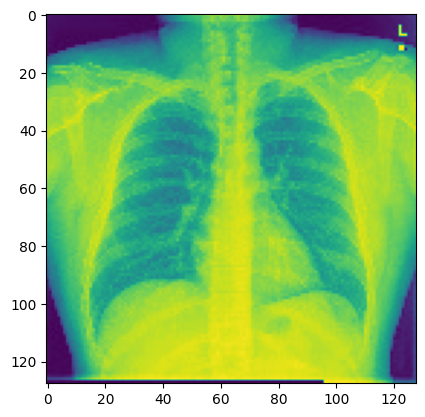

In [ ]:
imagenprueba = np.expand_dims(entradasNorm[100], axis = 2)
plt.imshow(imagenprueba)
plt.show()

In [ ]:
np.shape(np.expand_dims(imagenprueba, axis=3))

(128, 128, 1, 1)

In [ ]:
sample = entradasNorm[344]
imagen = modelo.predict(sample[tf.newaxis, ...], verbose = False)[0]

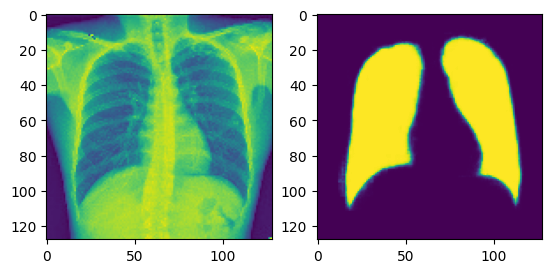

In [ ]:
fig, (axis1, axis2) = plt.subplots(1, 2)

axis1.imshow(sample)

axis2.imshow(imagen)

plt.show()

## Segmentación de fondo de ojo

In [ ]:
!mkdir /content/imagenes;
!unzip -q /content/drive/MyDrive/Internado/InternadoV1/Datasets/G1020_256256.zip -d /content/imagenes

mkdir: cannot create directory ‘/content/imagenes’: File exists


In [ ]:
pathNormal = '/content/imagenes/G1020_256256/Imagenes'
pathMascaras = '/content/imagenes/G1020_256256/Mascaras'

normal = os.listdir(pathNormal)
mascaras = os.listdir(pathMascaras)

normal.sort()
mascaras.sort()

print(normal[0:10])
print(mascaras[0:10])

['imagen_1.jpg', 'imagen_10.jpg', 'imagen_100.jpg', 'imagen_1000.jpg', 'imagen_1001.jpg', 'imagen_1002.jpg', 'imagen_1003.jpg', 'imagen_1004.jpg', 'imagen_1005.jpg', 'imagen_1006.jpg']
['imagen_1.jpg', 'imagen_10.jpg', 'imagen_100.jpg', 'imagen_1000.jpg', 'imagen_1001.jpg', 'imagen_1002.jpg', 'imagen_1003.jpg', 'imagen_1004.jpg', 'imagen_1005.jpg', 'imagen_1006.jpg']


In [ ]:
imNormal = [cv2.cvtColor(cv2.imread(pathNormal + '/' + i), cv2.COLOR_RGB2GRAY) for i in normal]
imMascaras = [cv2.cvtColor(cv2.imread(pathMascaras + '/' + i), cv2.COLOR_RGB2GRAY) for i in mascaras]

In [ ]:
entradas = np.array([i/np.max(i) for i in imNormal])
salidas = np.array([cv2.threshold(i/np.max(i), 0.2, 1, cv2.THRESH_BINARY)[1] for i in imMascaras])

In [ ]:
print("Cantidad de imagenes: {}".format(np.shape(imNormal)))
print("Cantidad de mascaras: {}".format(np.shape(imMascaras)))

Cantidad de imagenes: (1020, 256, 256)
Cantidad de mascaras: (1020, 256, 256)


In [ ]:
print(type(salidas[0][0][0]))

<class 'numpy.float64'>


1.0
0.0
(256, 256)


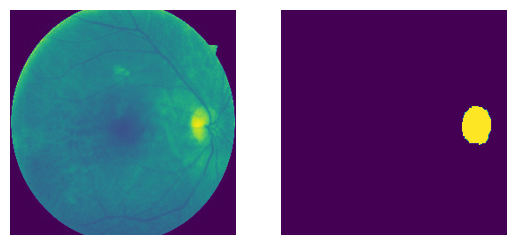

In [ ]:
imagen = randint(0, 1019)

print(np.max(entradas[imagen]))
print(np.min(entradas[imagen]))
print(np.shape(entradas[imagen]))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.axis('off')
ax1.imshow(entradas[imagen])

ax2.axis('off')
ax2.imshow(salidas[imagen])

plt.show()